# Testing sim scripts.

In [1]:
from shared.preface import *

box_name = 'L025N752'
box_ver = 'DMONLY/SigmaConstant00'
out_dir = f'{box_name}/{box_ver}'
nums_snaps = np.load(f'{out_dir}/nums_snaps.npy')
zeds = np.load(f'{out_dir}/zeds_snaps.npy')
zint = np.load(f'{out_dir}/z_int_steps.npy')
sint = np.load(f'{out_dir}/s_int_steps.npy')
print(nums_snaps)
print(zeds)
print(zint[:10])
print(sint[:10])

from shared.functions import read_DM_halo_index

with h5py.File(f'{out_dir}/MergerTree.hdf5') as tree:
    prog_IDs = tree['Assembly_history/Progenitor_index'][28,:]
    prog_IDs_np = np.array(np.expand_dims(prog_IDs, axis=1), dtype=int)

with open(f'{out_dir}/box_parameters.yaml', 'r') as file:
    box_setup = yaml.safe_load(file)

box_file_dir = box_setup['File Paths']['Box File Directory']
print(box_file_dir, type(box_file_dir))
print(prog_IDs_np.flatten())

np.savetxt('prog_IDs.txt', prog_IDs_np.flatten(), fmt='%d')

['0012' '0013' '0014' '0015' '0016' '0017' '0018' '0019' '0020' '0021'
 '0022' '0023' '0024' '0025' '0026' '0027' '0028' '0029' '0030' '0031'
 '0032' '0033' '0034' '0035' '0036']
[3.81000000e+00 3.43000000e+00 3.09000000e+00 2.79000000e+00
 2.52000000e+00 2.28000000e+00 2.06000000e+00 1.86000000e+00
 1.68000000e+00 1.51000000e+00 1.36000000e+00 1.21000000e+00
 1.08000000e+00 9.60000000e-01 8.50000000e-01 7.40000000e-01
 6.40000000e-01 5.50000000e-01 4.60000000e-01 3.70000000e-01
 2.90000000e-01 2.10000000e-01 1.40000000e-01 7.00000000e-02
 2.22044605e-16]
[0.         0.00382232 0.00779075 0.01191086 0.01618846 0.02062956
 0.02524041 0.0300275  0.03499758 0.04015762]
[0.00000000e+00 1.74215520e+15 3.55466566e+15 5.44047768e+15
 7.40266591e+15 9.44443913e+15 1.15691460e+16 1.37802813e+16
 1.60814920e+16 1.84765842e+16]
/projects/0/einf180/Tango_sims/L025N752/DMONLY/SigmaConstant00 <class 'str'>
[    43     44     55     60     62     69     71     74     66     65
     60     67     72  

In [1]:
# !python simulation_analytical.py -d L025N752/DMONLY/SigmaConstant00 --MW_halo --no-VC_halo --no-AG_halo

From 1 to and incl. 10000
Batch 1/1 done!
Sim time: 0.3595259091157156 min, 0.0059920984852619265 h.


In [3]:
out_dir = f'L025N752/DMONLY/SigmaConstant00'
output = np.load(f'{out_dir}/neutrino_vectors_analytical_batch1.npy')
print(output.shape)

(10000, 100, 6)


In [1]:
# !python simulation_numerical.py -d L025N752/DMONLY/SigmaConstant00 -st single_halos -mg 12.0 -mr 0.6 -hn 1

********Numerical Simulation: Mode=single_halos********
Halo batch params (Rvir,Mvir,cNFW):
[[253.5523526   12.24058042   6.9286026 ]]
***********************************
halo 1/1 ; snapshot 0012
halo 1/1 ; snapshot 0013
halo 1/1 ; snapshot 0014
halo 1/1 ; snapshot 0015
halo 1/1 ; snapshot 0016
halo 1/1 ; snapshot 0017
halo 1/1 ; snapshot 0018
halo 1/1 ; snapshot 0019
halo 1/1 ; snapshot 0020
halo 1/1 ; snapshot 0021
halo 1/1 ; snapshot 0022
halo 1/1 ; snapshot 0023
halo 1/1 ; snapshot 0024
halo 1/1 ; snapshot 0025
halo 1/1 ; snapshot 0026
halo 1/1 ; snapshot 0027
halo 1/1 ; snapshot 0028
halo 1/1 ; snapshot 0029
halo 1/1 ; snapshot 0030
halo 1/1 ; snapshot 0031
halo 1/1 ; snapshot 0032
halo 1/1 ; snapshot 0033
halo 1/1 ; snapshot 0034
halo 1/1 ; snapshot 0035
halo 1/1 ; snapshot 0036
***Running simulation: mode = single_halos***
halo=1/1, CPUs=128
Sim time: 3.8548975616499472 min, 0.06424829269416578 h.
Total time: 36.83711417246765 min, 0.6139519028744609 h.


# Final Content of notebook.

## Load, transform and plot simulation outputs.

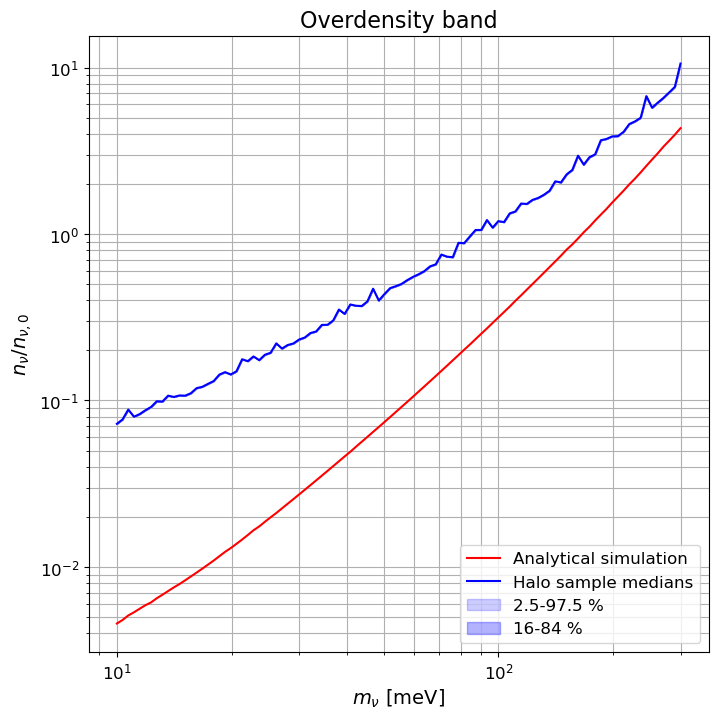

In [4]:
from shared.preface import *
import shared.functions as fct
from shared.shared_functions import Fermi_Dirac, number_density, velocity_to_momentum

def transform_simulation_outputs(out_dir):
    """
    Input sim_fullname specifies the simulation mode with additional information: e.g. "single_halos_40k_test1" or "spheres_5shells_10k_final".
    """

    # Try loading the equivalent output for the analytical simulation method.
    # If it hasn't been run yet, raise error and inform user.
    try:

        # Load neutrino vectors (positions and velocities) of the 10k batches, and concatenate them into a single array.
        batch_paths = glob.glob(
            f'{out_dir}/neutrino_vectors_numerical_batch*.npy'
        )
        vectors_ana = []
        for batch_path in batch_paths:
            vectors_ana.append(np.load(batch_path))
        vectors_ana = np.squeeze(np.array(vectors_ana))

        etas_ana = np.load(
            f'{out_dir}/number_densities_analytical.npy'
        )/N0

        analytical_out = True

    except FileNotFoundError:
        print('! Analytical simulation output not found !')
        analytical_out = False


    if 'single_halos' or 'spheres' in sim_fullname:

        # Load neutrino vectors (positions and velocities) of the 10k batches, and concatenate them into a single array.
        batch_paths = glob.glob(
            f'{out_dir}/neutrino_vectors_numerical_batch*.npy'
        )
        vectors_num = []
        for batch_path in batch_paths:
            vectors_num.append(np.load(batch_path))
        vectors_num = np.squeeze(np.array(vectors_num))

        etas_num = np.load(
            f'{out_dir}/number_densities_numerical.npy'
        )/N0

        if analytical_out:
            return vectors_ana, etas_ana, vectors_num, etas_num
        else:
            return vectors_num, etas_num
    
    else:
        # Load angle pairs and calculate overdensities for the all_sky mode.
        all_sky_output = np.load(f'{out_dir}/number_densities_numerical.npy')
        angle_pairs = all_sky_output[:, :2]
        etas_numerical = all_sky_output[:, 2:]/N0

        return etas_numerical, angle_pairs


def analyze_simulation_outputs(
        etas, m_nu_range,
        box_name, box_ver,
        plots_to_make, ylims, Mertsch=False,
        # vectors, sim_fullname,
    ):

    # Figure directory.
    # fig_dir = f'figures/{box_name}/{box_ver}/{sim_fullname}'
    fig_dir = f'figures/{box_name}/{box_ver}'
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

    savefig_args = dict(
        bbox_inches='tight'
    )

    if Mertsch:
        etas_analytical = etas[0,:]
        etas_numerical = etas[1:,:]
    else:
        etas_numerical = etas[...]

    ### ================================== ###
    ### Figure of merit: overdensity band. ###
    ### ================================== ###

    fig, ax = plt.subplots(1,1)

    if 'overdensity_band' in plots_to_make:

        # Plot smooth simulation.
        ax.plot(
            m_nu_range*1e3, (etas_analytical-1), color='red', ls='solid', 
            label='Analytical simulation'
        )

        if etas_numerical.ndim <= 1:
            ax.plot(
                m_nu_range*1e3, (etas_numerical-1), color='blue', 
                label='medians'
            )
        else:
            nus_median = np.median(etas_numerical, axis=0)
            nus_perc2p5 = np.percentile(etas_numerical, q=2.5, axis=0)
            nus_perc97p5 = np.percentile(etas_numerical, q=97.5, axis=0)
            nus_perc16 = np.percentile(etas_numerical, q=16, axis=0)
            nus_perc84 = np.percentile(etas_numerical, q=84, axis=0)
            ax.plot(
                m_nu_range*1e3, (nus_median-1), color='blue', 
                label='Halo sample medians'
            )
            ax.fill_between(
                m_nu_range*1e3, (nus_perc2p5-1), (nus_perc97p5-1), 
                color='blue', alpha=0.2, label='2.5-97.5 %'
            )
            ax.fill_between(
                m_nu_range*1e3, (nus_perc16-1), (nus_perc84-1), 
                color='blue', alpha=0.3, label='16-84 %'
            )

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title(f'Overdensity band')
        ax.set_xlabel(r'$m_{\nu}$ [meV]')
        ax.set_ylabel(r'$n_{\nu} / n_{\nu, 0}$')
        # ax.set_ylim(ylims[0], ylims[1])
        plt.grid(True, which="both", ls="-")
        plt.legend(loc='lower right')


        plt.savefig(fig_dir, **savefig_args)
        plt.show()

    ### ================================== ###
    ### Figure of merit: overdensity band. ###
    ### ================================== ###



box_name = 'L025N752'
box_ver = 'DMONLY/SigmaConstant00'
out_dir = f'{box_name}/{box_ver}'
sim_fullname = ''
vecs_ana, etas_ana, vecs_num, etas_num = transform_simulation_outputs(out_dir)
etas_combined = np.stack((etas_ana, etas_num), axis=0)

neutrino_massrange = np.load(f'{out_dir}/neutrino_massrange_eV.npy')*eV
analyze_simulation_outputs(
    etas=etas_combined, 
    m_nu_range=neutrino_massrange,
    box_name=box_name, 
    box_ver=box_ver,
    plots_to_make=('overdensity_band', 'vels'), 
    # ylims=(1e-3, 1e2),
    ylims=(0, 1e-2),
    Mertsch=True
)

In [42]:
with open(f'{out_dir}/box_parameters.yaml', 'r') as file:
    box_setup = yaml.safe_load(file)

box_file_dir = box_setup['File Paths']['Box File Directory']
DM_mass = box_setup['Content']['DM Mass [Msun]']*Msun

print(DM_mass)

coords = np.load('L025N752/DMONLY/SigmaConstant00/initial_velocities.npy')
print(coords[:3,:])

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# ss = 1
# x, y, z = coords[:,0][::ss], coords[:,1][::ss], coords[:,2][::ss]
# ax.scatter(x,y,z, alpha=1, s=0.1)
# plt.show()

1.604054176342484e+72
[[-0.00000000e+00 -0.00000000e+00  3.23853730e-13]
 [-0.00000000e+00 -0.00000000e+00  3.60441142e-13]
 [-0.00000000e+00 -0.00000000e+00  4.01162022e-13]]


6.157721095044512